In [99]:
# filepath utilities
import os
from os.path import dirname, basename, join
# number crunching
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# input structuring
import flopy

In [703]:
git_dir = os.getcwd()
while basename(git_dir) != 'challenge':
    git_dir = dirname(git_dir)
usr_dir = git_dir[:]
while basename(usr_dir) != 'Documents':
    usr_dir = dirname(usr_dir)
usr_dir = dirname(usr_dir)
all_dat_dir = git_dir+'/data'

In [18]:
regions = os.listdir(all_dat_dir)

region = 'Germany'
region = regions[0]

dat_dir = all_dat_dir + '/' + region

In [19]:
os.listdir(dat_dir)

['heads.csv', 'head_data.png', 'input_data.csv', 'README.md']

In [27]:
with open(dat_dir +'/README.md', 'r') as f:
    print(f.read())


# Monitoring well Germany

## Location description
The well is situated in Bavaria, in the Upper Jurassic Malm Karst aquifer. It is a deep, confined aquifer (partly artisian), which is overlain by a local alluviual aquifer in a small river valley. Surface elevation is about 375 masl, depth to groundwater 0.9 m on average.

![Head data](head_data.png)

## Input data description

The following input data are provided to model the head time series. This data were collected from the E-OBS dataset 
v25.0e at 0.1deg grid size.

- Daily Precipitation (RR) in mm/d.
- Daily mean temperature (TG) in degree Celsius.
- Daily minimum temperature (TM) in degree Celsius.
- Daily maximum temperature (TX) in degree Celsius.
- Daily averaged sea level pressure (PP) in hPa.
- Daily averaged relative humidity (HU) in %.
- Daily mean wind speed (FG) in m/s.
- Daily mean global radiation (QQ) in W/m2.
- Potential evaporation (ET) computed with Makkink in mm/d.

## Calibration and testing data

The head data

# Model Overview
1. Create general discretization with dimensions sufficient large to reduce boundary effects (start about 10 times aquifer thickness)
2. Start with coarse row, column (500 m by 500m) then reduce as needed (100m by 100m lower end)
3. Discretize aquifer top and bottom from information provied
4. Enter general geologic parameters based on literature review
5. Add recharge/ET to domain dependent on expected vegetation and soil
6. Prepare observation package for well centralized in domain
7. Simple solver package with PCGN should suffice, basic OC
8. Run model, post-process and determine whether manual calibration or UCODE should be pursued first. And identify all parameters that require calibration (e.g., those without measured values and expected to be sensitive)

In [583]:
# Meta data for model
# summary sheet
# meta = pd.read_excel('GW Modeling Challenge.xlsx', sheet_name = 'Problem Summaries')
# meta = meta[meta.Country==region]

# long format meta data
meta = pd.read_excel('GW Modeling Challenge.xlsx', sheet_name = region, index_col='variable')
# strip out start and end dates
strt_date, cal_end_date = meta.loc['Training_period', 'value'].split(' to ')
val_strt_date, end_date = meta.loc['Training_period', 'value'].split(' to ')
# could improve but works for now
strt_date = pd.to_datetime(strt_date)
end_date = pd.to_datetime(end_date)
cal_end_date = pd.to_datetime(cal_end_date)
val_strt_date = pd.to_datetime(val_strt_date)

# meta[date_cols] = meta[date_cols.apply(pd.to_datetime, errors='coerce')

## Plotting to understand system dynamics

In [136]:
# dataframe to relate variable to label (e.g. rr : Precipitation)
label_dict = pd.read_excel('GW Modeling Challenge.xlsx', sheet_name = 'data_dict')


In [160]:
obs = pd.read_csv(join(dat_dir,'heads.csv'), parse_dates=['Date'], index_col='Date')

In [562]:
# load input data
all_data = pd.read_csv(join(dat_dir,'input_data.csv'), parse_dates=['time'], index_col='time')

# convert rainfall and et from mm/day to m/day
all_data[['rr','et']] /= 1000

# take monthly averages for data review plotting
mon_data = all_data.resample('MS').mean()
# precip and et should be summed
mon_data[['rr','et']] = all_data.resample('MS').sum()[['rr','et']]

all_long = all_data.melt(ignore_index=False)
mon_long = mon_data.melt(ignore_index=False)



(11808.0, 17166.0)

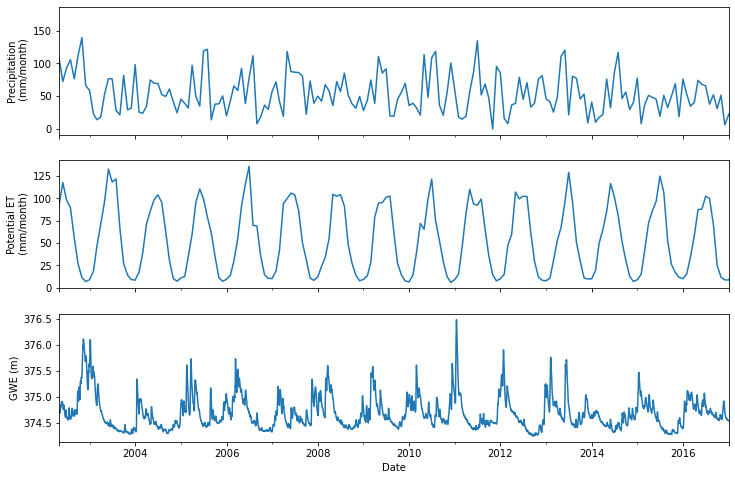

In [179]:
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True)
ax_n = ax[-1]
ax_n.set_ylabel('GWE (m)')
obs.plot(ax=ax_n, legend=False)

ax_n = ax[0]
ax_n.set_ylabel('Precipitation\n (mm/month)')
mon_data.plot(y='rr',ax=ax_n, legend=False)

ax_n = ax[1]
ax_n.set_ylabel('Potential ET\n (mm/month)')
mon_data.plot(y='et',ax=ax_n, legend=False)

ax[0].set_xlim(obs.index.min(), obs.index.max())
# sns.relplot(data = mon_long[mon_long.variable.isin(['rr','tg','et'])], 
#                             x = 'time', y='value',col='variable', col_wrap=1,
#            facet_kws = {'sharey':False}, kind='line', height=3, aspect = 3)

### Time series analysis
Andrew:  
+ There is a clear seasonality of the potential evapotranspiration with highs in summer and lows in winter.  
+ The precipitation occurs throughout the entire year, with what might appear to be some low points in the fall and spring.  
+ The groudnwater elevation shows strong seasonal impacts, similar to what we would see in a streamflow hydrograph. The notes indicate this is a confined artisian aquifer overlain by an alluvial aquifer so the question is whether this signal is coming from a vertical connection with the overlying aquifer or from some form of mountain front recharge on the edges of the aquifer where the karst is nearer to the surface.  

Let's start with assuming some recharge passes from the alluvial system to the deeper aquifer based on precipitation minus PET in the summer with an estimated crop coefficient.

## Discretization - time and space

In [311]:

# Transient -> might want to think about making SP1 steady
# strt_date = meta.strt_date.values[0]
# end_date = meta.end_date.values[0]

dates = pd.date_range(strt_date, end_date, freq='D')
# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one month, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# stress period unit is days so need to increase stress period
perlen[1:] = dates.days_in_month
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Bimonthly timesteps
nstp = np.ones(nper)*np.append(np.ones(1), 1*np.ones(nper-1))

In [590]:
# we are going to need to do some digging about the aquifer thicknesses
# thick = 100
thick = meta.loc['thickness'].sort_values('layer')['value'].values

nlay = thick.shape[0] 


In [591]:
# starting with 2 km by 2 km grid as we are not given any aquifer thickness to begin
nrow=20
ncol=20
delr=100
delc=100
rotation=0


In [707]:
model_ws = join(usr_dir, 'WRDAPP', 'GWFlowModel', 'challenge', 'mf',region)


m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
                          version = 'mf2005', model_ws=model_ws)
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
#                           version = 'mf2005', model_ws='data')
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               rotation=rotation, 
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [708]:
# surface elevation comes from metadata
top_elev = meta.loc['Surface_elevation_m','value']
bot_elev = top_elev - thick
# set modflow discretization for model top and bottom of each layer
m.dis.top = top_elev
m.dis.botm = bot_elev

In [709]:
ibound = np.ones(m.dis.botm.shape)
# need to take off because it is 1 based
# have starting heads at ground surface so every cell is active
strt = m.dis.top

In [710]:
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

# Geology - LPF

In [599]:
gel_meta = meta.sort_values('layer')
# convert from m/s to m/d
kx = gel_meta.loc['kx','value'].values*86400
hani = gel_meta.loc['hani','value'].values
vani = gel_meta.loc['vani','value'].values
ss = gel_meta.loc['ss','value'].values
sy = gel_meta.loc['sy','value'].values


# 0—indicates VKA is vertical hydraulic conductivity
layvka = 1

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# laytyp = [1,1,1,0,0,0,0,0]
laytyp=[1, 0 ]
laywet=laytyp[:]
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
# laywet = 1 means layers can be rewetted.
#ipakcb = 53 means cell-by-cell budget is saved because it is non zero (default is 53)
# removed sy while ss is active as storage coefficient rather than specific storage
# storagecoefficient = True

lpf = flopy.modflow.ModflowLpf(model = m, hk =kx, chani = 0, hani = hani,
                               layvka = layvka, vka = vani, ss=ss,
                               laytyp=laytyp, laywet = laywet, ipakcb=53,
                              storagecoefficient=False)

In [600]:
lpf.write_file()

Errors and/or Warnings encountered.
  see C:\Users\andrewc\Documents\GitHub\challenge\submissions\team_UCD\mf\Germany\LPF.chk for details.



## GHB GW Flow (as needed)
The GHB can appear in two directions:
1. From the edges of the valley where one might imagine it as mountain front recharge
2. From up and downstream where one might imagine it as groundwater inflow coming in as a result of upstream recharge either from the alluvium or further up at the valley edges into mountainfront recharge and the downstream flows down into lower segments

Now with two layers, the question is whether groundwater inflow is necessary in shallow aquifer in addition to deep aquifer.

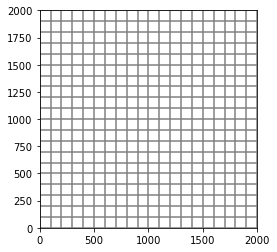

In [389]:
m.modelgrid.plot()

In [605]:
thick[nlay-1]

100

In [606]:
avg_dtw = meta.loc['Avg_depth_GW_m','value']
# set top and bottom inflows and outflows
rowbot = np.zeros(ncol)
colbot = np.arange(0,nrow)
hbot = np.full(ncol, top_elev - avg_dtw + meta.loc['row_grad','value']*delc*nrow/2)

# downstream groundwater outflow
rowtop = np.ones(ncol)*(nrow-1)
coltop = np.arange(0,nrow)
htop = np.full(ncol, top_elev - avg_dtw - meta.loc['row_grad','value']*delc*nrow/2)

ghb_rows = np.append(rowbot, rowtop)
ghb_cols = np.append(colbot, coltop)
ghb_layer = np.full(len(ghb_rows), nlay-1)
ghb_h = np.append(hbot, htop)
# conductance is just aquifer conductivity times cell dimensions (col width, layer thickness)
ghb_cond = np.full(len(ghb_rows), kx[nlay-1]*delc*thick[nlay-1])

ghb_arr = np.transpose([ghb_layer, ghb_rows, ghb_cols, ghb_h, ghb_cond])

In [607]:
# some groundwater flow term is needed to accomodate the difference bewtween recharge and pumping for steady state
# # if needed for water budget, the boundary edges of the model can be set as general head cells with the 
# # long term average groundwater elevation
ghb_spd = {}
# # 'lay','row','col','head','cond']
ghb_spd[0] = ghb_arr

ghb = flopy.modflow.ModflowGhb(model = m,stress_period_data =  ghb_spd,ipakcb=53)
# ghb.check()

In [608]:
ghb.write_file()


## Basic Soil Water Budget

In [563]:
# assume simple crop coefficient, check if sensitive
kc = 1.0
# for Germany recharge will be to the
# assume infiltration is the amount of recharge not used by ET
# for germany there is most likely some riparian vegetation in the alluvial system
all_data['infil'] = all_data.rr- all_data.et*kc
# when ET is greater than precip infiltration is zero 
all_data.loc[all_data.infil < 0, 'infil'] = 0

# not all of the infiltration percolates to the deeper aquifer so add a percolation scaling term
# assuming that some of the water most is a return flow to a channel, some returns to the soil zone where it 
# becomes ET again
perc_frac = 1.0
all_data['deep_perc'] = all_data.infil * perc_frac

## Pumping (as needed)
It looks like there is agricultural development in the Bavarian region so we can assume some effects from pumping, but difficult to assess whether they would be near by both in the xy and z

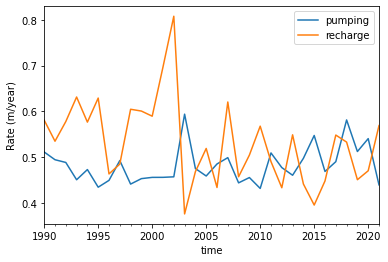

In [565]:
# assume when ET is greater than rainfall there is irrigation to account for the offset
all_data['pump_rate'] = kc*(all_data.et - all_data.rr)
all_data.loc[all_data.pump_rate < 0, 'pump_rate'] = 0


# subset steady state period data
ss_data = all_data[all_data.index<strt_date].copy()

# looks like pumping would total about a 500 mm each year
fig,ax=plt.subplots()
all_data.pump_rate.resample('AS').sum().plot(ax=ax,label='pumping')
all_data.deep_perc.resample('AS').sum().plot(ax=ax, label='recharge')
plt.ylabel('Rate (m/year)')
plt.legend()

In [609]:
rows = np.repeat(np.arange(0,nrow), ncol)
cols = np.tile(np.arange(0,ncol), nrow)
wel_df = pd.DataFrame(np.transpose([rows,cols]), columns=['row','col'])
wel_df['layer'] = nlay - 1
wel_df['pump'] = 0
# wel_df

In [610]:
# create empty dictionary to fill with stress period data
wel_dict = {}
# steady state period
wel_df['pump'] = -ss_data.pump_rate.mean()*(delr*delc)
wel_dict[0] = wel_df[['layer','row', 'col','pump']].values

# import flux from data into wel package
for n in np.arange(1,len(dates)+1):
    # the first TR spd references 1989-01-01 so need to -1
    t = dates[n-1]
    # update pumping for each stress period
    wel_df['pump'] = -all_data.loc[t,'pump_rate']*(delr*delc)
    # 'layer','row','column', 'pump'
    wel_dict[n] = wel_df[['layer','row', 'col','pump']].values
    
    
# # specify cbc file as the same as upw
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_dict,ipakcb=53)
# wel.check()

In [611]:
wel.write_file()

## Recharge

In [661]:
# each stress period dict entry filled by array of recharge rates
rch_dict = {}

# assign steady state recharge
rch_arr = np.ones((nrow,ncol))*ss_data.deep_perc.mean()
rch_dict[0] = rch_arr


for n in np.arange(1,len(dates)+1):
    # the first TR spd references 1989-01-01 so need to -1
    t = dates[n-1]
    # create empty array to be filled with recharge rates (L/T)
    rch_arr = np.zeros((nrow,ncol))
    # fill recharge array for prms data, take off 1 because grid_p starts at 1
    rch_arr[:,:] = all_data.deep_perc[t]
    # add the recharge to the dictionary
    rch_dict[n] = rch_arr*bas.ibound.array[0,:,:] 

# # nrchop = 3, to highest active cell
# # specify cbc output to same as upw file
# recharge should be to layer 1 only (alluvium)
rch =flopy.modflow.ModflowRch(model = m, nrchop=1, rech = rch_dict, ipakcb=53)


In [662]:
rch.write_file()

Errors and/or Warnings encountered.
  see C:\Users\andrewc\Documents\GitHub\challenge\submissions\team_UCD\mf\Germany\RCH.chk for details.



## HOB package
Represent observation well in center of domain or within a cell

In [670]:
obs = pd.read_csv(join(dat_dir,'heads.csv'), parse_dates=['Date'], index_col='Date')

obs['row'] = int(nrow/2)
obs['col'] = int(ncol/2)
obs['layer'] = nlay-1
obs['group'] = 'karst'
obs['obs_name'] = ('karst_'+pd.Series(np.arange(0,len(obs)).astype(str)).str.zfill(4)).values
obs['totim'] = (obs.index-pd.to_datetime(strt_date)).days+1

# obs1 = obs.copy().assign(layer=0)
# obs1['obs_name'] = ('sand_'+pd.Series(np.arange(0,len(obs1)).astype(str)).str.zfill(4)).values
# obs1['group'] = 'sand'

# obs = obs.append(obs1)

In [671]:
# create a new hob object
obs_data = []
for i in obs.group.unique(): # for each well location
    obs_temp = obs[obs.group==i]
    # tsd is the totim and head obs
    tsd = obs_temp[['totim','head']].values
    # need to use the same layer where pumping is, average depth is 
    temp = flopy.modflow.HeadObservation(m, layer= obs_temp['layer'].unique()[0], row=obs_temp['row'].unique()[0], 
                                                  column=obs_temp['col'].unique()[0],
                                                  time_series_data=tsd,
                                                  obsname=obs_temp['group'].unique()[0],
                                         names = obs_temp['obs_name'].values.tolist())
    # correct time offset from stress period to be 0
    temp.time_series_data['toffset'] = 0
    obs_data.append(temp)


In [672]:
hob = flopy.modflow.ModflowHob(m, iuhobsv=50, hobdry=-9999., obs_data=obs_data, unitnumber = 39,
                              hobname = 'MF.hob.out')
hob.write_file()


## Output control

In [619]:
months = pd.date_range(strt_date, end_date, freq='MS')

In [620]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = {}
# spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}
for t in months:
    # save head, budget every month
    n = np.where(dates ==t)[0][0]
    spd[(n,0)] = ['print budget', 'save head', 'save budget']

oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

## Solver

In [621]:
# GMG is more successful than pcg which is fine for steady state model
# mxiter, max outer, iiter = max inner, hclose = head change criterion for convergence, 
# rclose = residual criterion for convergence


# gmg = flopy.modflow.ModflowGmg(model = m, mxiter=50, iiter=30, hclose = 1e-5, rclose = 1e-5)
# iter_mo max outer iters, ter_mi = max inner iters, close_r residual criterion for stopping iteration
# close_h is alternate criterion for nonlinear problem, and is head closure which should be smaller than residual closer
# ipunit =0 means no info on solver, ipunit=1 means output about solver issues is written
# if iter_mo >1 then closer_r is used not close_h and closer_r is compared to 
# the square root of the inner product of the residuals (the residual norm)
# adamp =0 is std damping, adamp=1 is adaptive damping that further decreases or increases damping based on picard
# iteration sucess
#adamp is 0.7 to resolve issues with heads oscillating near solution +1 m
# damp_lb = lower bound, rate_d is rate of increase of damping based picard iteration success
pcgn = flopy.modflow.ModflowPcgn(m, iter_mo = 100, iter_mi=60, close_r=1e-02, close_h=1e-04, ipunit=28)
                               # adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)


In [622]:
# m.write_name_file()

## Write input

In [615]:
m.write_input()


# UCODE input
Calibration data is based solely on the one observation well.
The calibration parameters could be pretty much any of the metadata so it would make sense to make a copy of that whole unit and then make a jtf version of it for the values.

In [697]:
meta.to_csv(join(model_ws, 'parameters.csv'))

In [665]:

def write_hob_jif_dat(model_ws, hobout, statflag=False):
    ''' Create the JIF and DAT files for the HOB package based on standard MODFLOW output
    and create a StandardFile for UCODE'''
    obsoutnames = hobout['OBSERVATION NAME']
    obs_vals = hobout['OBSERVED VALUE']

    header = 'jif @\n'+'StandardFile  1  1  '+str(len(obsoutnames))
    # obsoutnames.to_file(m.model_ws+'/MF.hob.out.jif', delimiter = '\s+', index = )
    np.savetxt(model_ws+'/MF.hob.out.jif', obsoutnames.values,
               fmt='%s', delimiter = r'\s+',header = header, comments = '')
    # ucode wants the observed value already written out to the obs_table
    # the simulated equivalent and obs name must be referenced 
    # in the hob.out.jif file
    # file1.writelines('  NROW='+str(len(obs_vals))+' NCOL=3 COLUMNLABELS \n')
    # file1.writelines('  ObsName GroupName ObsValue'+'\n')
    cols = ['OBSERVATION NAME','group','OBSERVED VALUE']
    stat=''
    if statflag==True:
        stat = ' Statistic StatFlag'
        cols +=['Statistic','StatFlag']

    header = 'BEGIN Observation_Data Table\n'+\
        'NROW='+str(len(obs_vals))+' NCOL='+str(len(cols))+' COLUMNLABELS \n'+\
        'ObsName GroupName ObsValue'+stat

    footer = 'End Observation_Data'
    # add column for group
    hobout['group'] = 'Heads'
    # get array of just strings
    hob_arr = hobout.loc[:,cols].values
    # pull out observed value and name of obs
    np.savetxt(model_ws+'/hob_obs_table.dat', hob_arr,
               fmt='%s', header = header, footer = footer, comments = '' )

In [667]:
hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0)


write_hob_jif_dat(model_ws, hobout)

# Post-processing

1.6300383272020014

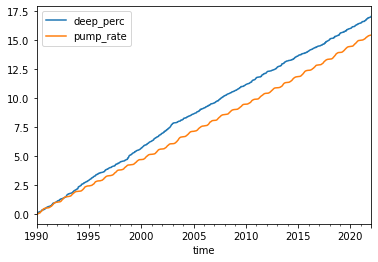

In [624]:
# all_data.plot(y=['deep_perc','pump_rate'])
all_data.cumsum().plot(y=['deep_perc','pump_rate'])
# long term rise in water recharge
all_data.sum().deep_perc - all_data.sum().pump_rate

In [694]:
hd_sand[-1,0]/31
# why is the model run head output 30 times what it should be?
# did the units get messed up

5236.354838709677

In [692]:
hdobj = flopy.utils.HeadFile(join(model_ws,'MF.hds'))
hd_sand = hdobj.get_ts((0, int(nrow/2),int(ncol/2)))
# hd_sand['date'] = 
strt_date + (hd_sand[:,0]/3-1).astype('timedelta64[D]') 

array(['2002-05-01T00:00:00.000000000', '2003-03-16T00:00:00.000000000',
       '2004-01-10T00:00:00.000000000', '2004-11-26T00:00:00.000000000',
       '2005-10-12T00:00:00.000000000', '2006-08-08T00:00:00.000000000',
       '2007-06-24T00:00:00.000000000', '2008-04-19T00:00:00.000000000',
       '2009-03-06T00:00:00.000000000', '2010-01-20T00:00:00.000000000',
       '2010-10-08T00:00:00.000000000', '2011-08-25T00:00:00.000000000',
       '2012-06-20T00:00:00.000000000', '2013-05-06T00:00:00.000000000',
       '2014-03-02T00:00:00.000000000', '2015-01-16T00:00:00.000000000',
       '2015-12-03T00:00:00.000000000', '2016-09-28T00:00:00.000000000',
       '2017-08-14T00:00:00.000000000', '2018-06-10T00:00:00.000000000',
       '2019-04-26T00:00:00.000000000', '2020-03-12T00:00:00.000000000',
       '2020-12-17T00:00:00.000000000', '2021-11-02T00:00:00.000000000',
       '2022-08-29T00:00:00.000000000', '2023-07-16T00:00:00.000000000',
       '2024-05-11T00:00:00.000000000', '2025-03-27

In [663]:
hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,
                     names = ['SIM','OBS','obs_nam'],
                     dtype = {'SIM':float,'OBS':float,'obs_nam':object})
# join for plotting dates
hobout = hobout.join(obs.reset_index().set_index('obs_name'), on='obs_nam')
hobout['obs_group'] = 'obs'
# convert dry cells to NAs
hobout.loc[hobout.SIM==-9999, 'SIM'] = np.NaN


<AxesSubplot:xlabel='Date'>

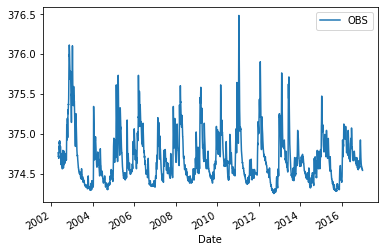

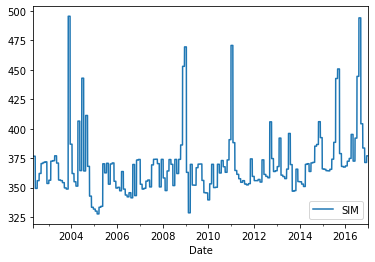

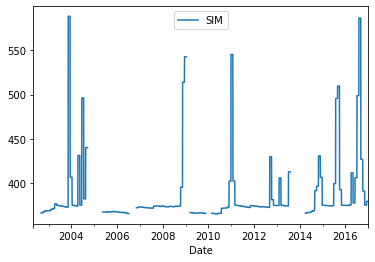

In [664]:
hobout.plot(x='Date',y='OBS')
hobout[hobout.group=='karst'].plot(x='Date',y='SIM')
hobout[hobout.group=='sand'].plot(x='Date',y='SIM')


In [540]:
hobout_diff = hobout.copy()
# calculate differences in head for different observation statistic
for n in hobout_diff.obs_group.unique():
    df_n = hobout_diff[hobout.obs_group ==n].copy()
    # find error between sim and obs for difference over time
    hobout_diff.loc[(hobout_diff.obs_nam.isin(df_n.obs_nam)),'OBS'] = df_n.OBS.diff()
    hobout_diff.loc[(hobout_diff.obs_nam.isin(df_n.obs_nam)),'SIM'] = df_n.SIM.diff().values

    # positive shows overestimating, negative shows underestimating
hobout_diff = hobout_diff.dropna(subset=['OBS'])

In [541]:
def error_stats(hobout, hob_type = ''):
    # positive shows overestimating, negative shows underestimating
    hobout['Error'] = hobout.OBS - hobout.SIM
    hobout['Abs_Error'] = hobout.Error.abs()
    hobout['Sq_Err'] = hobout.Error**2

    err_stats = hobout.Error.describe()[['count','mean','std','min','max']]
    err_stats['Abs_Error'] = hobout.Abs_Error.mean()
    err_stats['Range'] = hobout.OBS.max()-hobout.OBS.min()
    err_stats['Sum_Sq_Err'] = hobout.Sq_Err.sum()
    err_stats = err_stats.round(3)
    print(err_stats)

    import csv
    err_stats = err_stats.astype(str).str.ljust(10).reset_index()
    err_stats['index'] = err_stats['index'].str.ljust(15)

#     with open(fig_dir+'/'+hob_type+'Head_obs_statistics.txt', 'w',newline='') as f:
#         f.write('# Model Head Observation Statistics\n')
#         err_stats.to_csv(f,index=False, mode="a", sep=',') #, quoting=csv.QUOTE_NONE, escapechar=' '
    return(hobout)
hobout = error_stats(hobout) 
hobout_diff = error_stats(hobout_diff, hob_type='diff') 

count         5.359000e+03
mean         -2.783697e+03
std           5.396896e+04
min          -2.858817e+05
max           4.857250e+04
Abs_Error     3.635458e+04
Range         2.230000e+00
Sum_Sq_Err    1.564750e+13
Name: Error, dtype: float64
count         5.358000e+03
mean         -2.950000e-01
std           1.281075e+04
min          -3.269358e+05
max           2.640822e+05
Abs_Error     1.346789e+03
Range         5.200000e-01
Sum_Sq_Err    8.791659e+11
Name: Error, dtype: float64


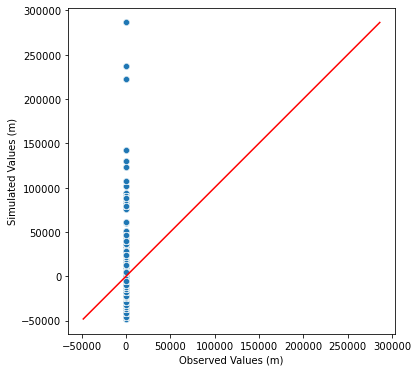

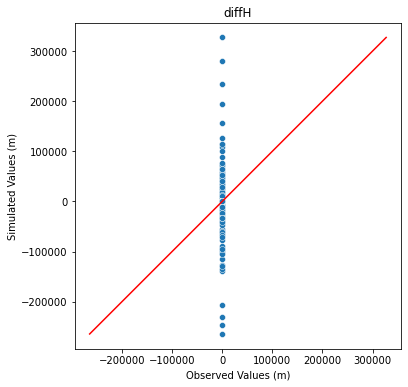

In [542]:
import seaborn as sns
def hob_sim_obs(hobout, plt_id=''):
    # get boundary values for plotting a 1:1
    hobmax = hobout.loc[:,['SIM','OBS']].max().max()
    hobmin = hobout.loc[:,['SIM','OBS']].min().min()

    fig,ax = plt.subplots(figsize=(6,6))
    # plot observed vs simulated values
#     hobout.plot.scatter(x='SIM',y='OBS',marker='.', ax=ax)
    sns.scatterplot(data=hobout, x='OBS', y='SIM', ax=ax)

    # plot 1:1 line
    ax.plot([hobmin,hobmax],[hobmin,hobmax],'red')
    # ax.set_aspect(1)
    plt.axis('square')
    plt.ylabel('Simulated Values (m)')
    plt.xlabel('Observed Values (m)')
    plt.title(plt_id)
#     plt.savefig(fig_dir+'sim_vs_obs_'+plt_id+'.png', dpi=300, bbox_inches='tight')

hob_sim_obs(hobout)

hob_sim_obs(hobout_diff, plt_id = 'diffH')
